In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, probplot, norm
from scipy.stats.stats import pearsonr
from IPython.display import display
import sys

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
test_df = pd.read_csv('data/test.csv', index_col='Id')

In [3]:
print(train_df.shape)
test_df.shape

(1460, 80)


(1459, 79)

In [4]:
catCols = list(train_df.select_dtypes(include='object').columns)
print(f'Number of categorical variables: {len(catCols)}')
print(catCols)

Number of categorical variables: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [5]:
numCols = list(train_df.select_dtypes(include='number').columns)
print(f'Number of numerical variables: {len(numCols)}')
print(numCols)

Number of numerical variables: 37
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


<b> Plot Phân phối SalePrice </b>

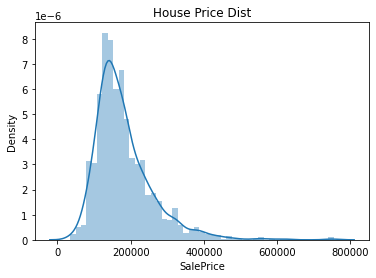

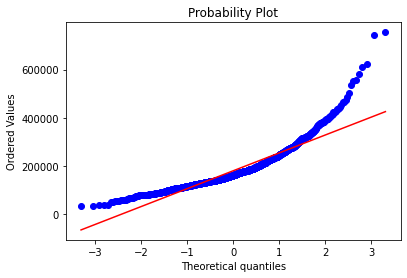

In [6]:
sns.distplot(train_df.SalePrice)
plt.title('House Price Dist');
fig = plt.figure()
res = probplot(train_df.SalePrice, plot=plt);

Nhận xét: SalePrice có dạng hơi lệch khỏi phân phối chuẩn một chút về bên phải

#### Outliers

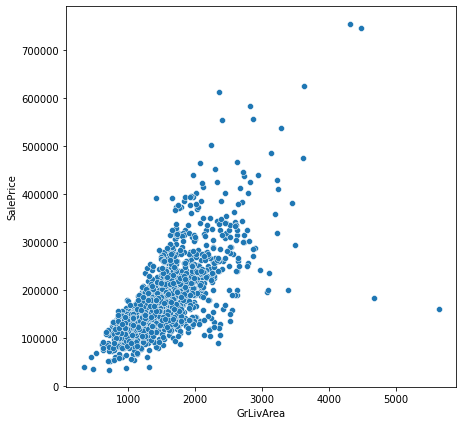

In [7]:
# Xem mối quan hệ giữa GrLivArea và SalePrice
fg = plt.figure(figsize=(7,7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice']);

<b>Nhận xét: 2 điểm ở góc phải bên dưới khá khác biệt so với các điểm còn lại, đi ngược lại xu hướng, nên khả năng rất cao đây là 2 điểm ngoại lai </b> <br>
<b> --> Nên ta sẽ loại bỏ chúng </b>

In [8]:
outlier_index = train_df[(train_df.GrLivArea > 4000) & (train_df.SalePrice < 200000)].index
train_df.drop(outlier_index,axis=0, inplace=True)

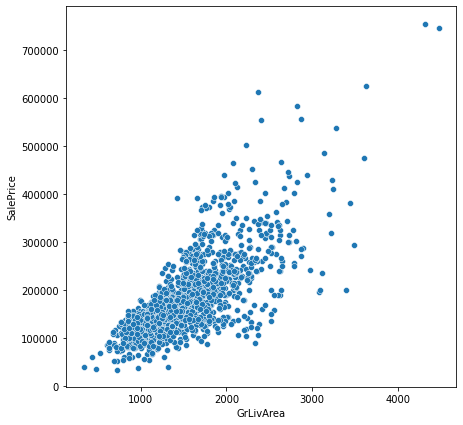

In [9]:
# Xem mối quan hệ giữa GrLivArea và SalePrice sau khi đã bỏ outliers
fg = plt.figure(figsize=(7,7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice']);

<b>Đưa SalePrice về dạng phân phối chuẩn </b>

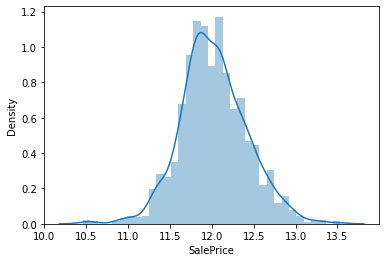

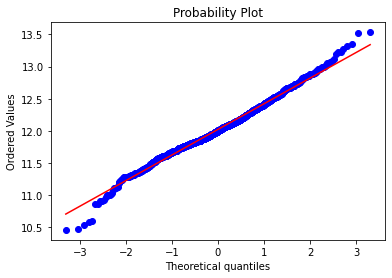

In [10]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.distplot(train_df['SalePrice'])
plt.figure()
probplot(train_df['SalePrice'], plot=plt);

#### <b>Ma trận tương quan</b>

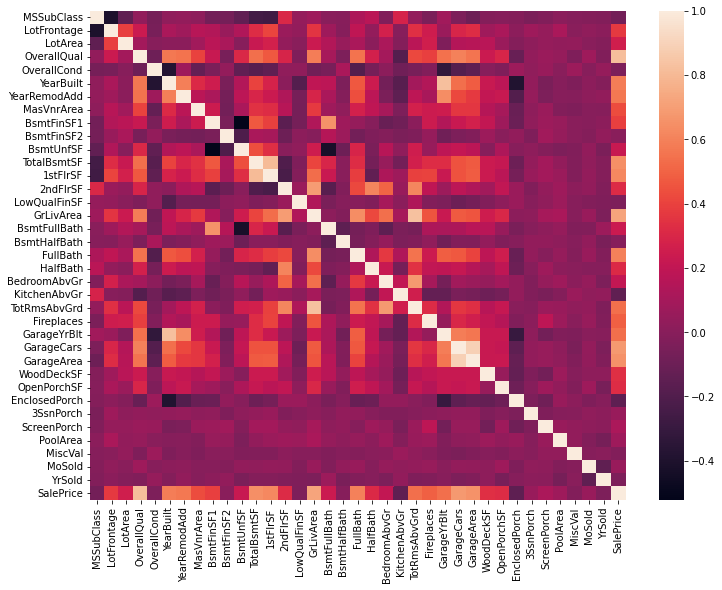

In [11]:
corr = train_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr);

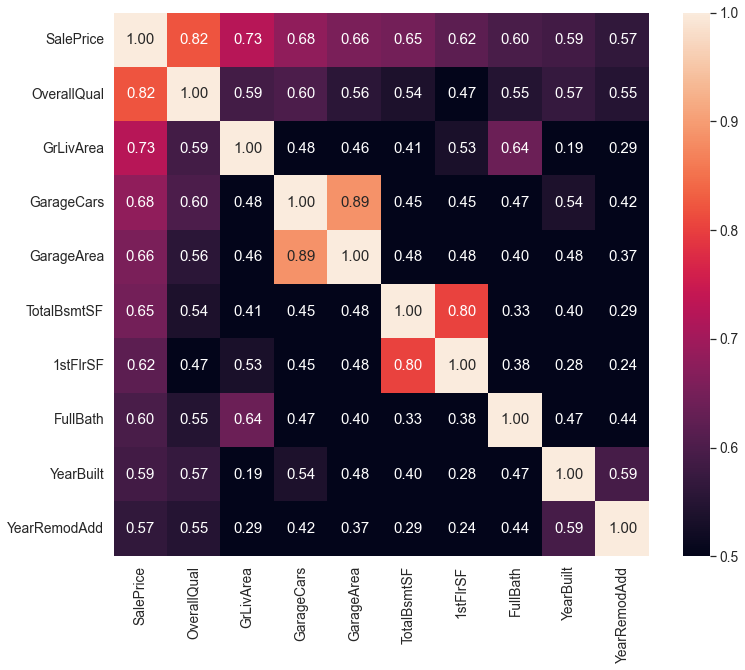

In [12]:
# 10 đặc trưng có độ tương quan lớn nhất với SalePrice
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(12,10))
# Select correlations greater than 0.5
hm = sns.heatmap(cm, annot=True,fmt='.2f', yticklabels=cols.values, xticklabels=cols.values, vmin = 0.5, vmax=1.)
plt.show();

<b>Nhận xét</b>:
* OverallQual, GrLivArea, TotalBsmtSF tương quan nhiều với SalePrice.
* GarageCars và GarageArea khá tương đồng nhau vì diện tích Garage càng lớn thì càng để được nhiều Oto, và ngược lại, nên có thể bỏ 1 cái, giữ lại GarageCars vì có độ tương đồng với SalePrice lớn hơn.
* TotalBsmtSF và 1stFlrSF cũng khá tương đồng nhau, giữ lại TotalBsmtSF
* FullBath: Không đóng vai trò lớn trong việc quyết định giá nhà.
* TotRmsAbvGrd và GrLivArea: giá tương đồng nhau --> bỏ TotRmsAbvGrd
* Giữ lại YearBuilt: vì quan trọng trong việc quyết định giá nhà.

### PLot những đặc trưng có độ tương quan cao với SalePrice

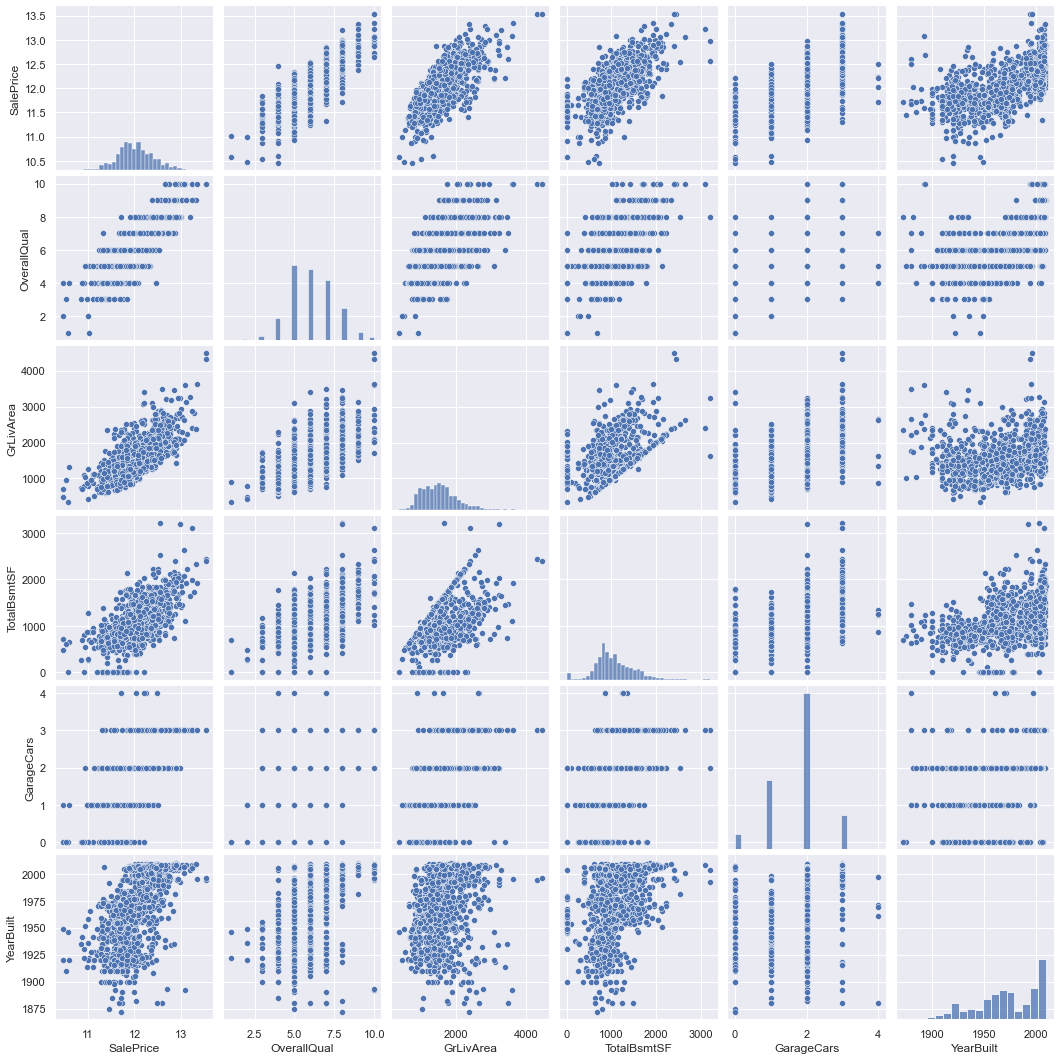

In [13]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt']
sns.pairplot(train_df[cols])
plt.show();

<b>Kết hợp train và test data</b>

In [10]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f'Shape all data:{all_data.shape}')


Shape all data:(2917, 79)


<b>Missing data</b>

In [11]:
missing_data_count = all_data.isna().sum()
missing_data_percent = missing_data_count / len(all_data) * 100
missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)
print('There are {} features that have missing values'.format(len(missing_data.index)))
missing_data.head(34)

There are 34 features that have missing values


,Count,Percent
PoolQC,2908,99.691
MiscFeature,2812,96.400
Alley,2719,93.212
Fence,2346,80.425
FireplaceQu,1420,48.680
LotFrontage,486,16.661
GarageFinish,159,5.451
GarageQual,159,5.451
GarageCond,159,5.451
GarageYrBlt,159,5.451


##### <b>Xử lý dữ liệu bị thiếu (missing values) </b> <br>
Dựa vào file mô tả data:

In [28]:
# PoolQC : NA là "No Pool".
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [29]:
# MiscFeature : NA là "no misc feature"
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [30]:
# Alley : NA là "no alley access"
all_data['Alley'] = all_data['Alley'].fillna('None')

In [31]:
# Fence : NA là "no fence"
all_data['Fence'] = all_data['Fence'].fillna('None')

In [32]:
# FireplaceQu : NA -> No FireplaceQu 
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [33]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [34]:
# GarageType, GarageFinish, GarageQual and GarageCond: thay thế NA bằng None
for col in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    all_data[col] = all_data[col].fillna('None')

In [35]:
# GarageYrBlt, GarageArea and GarageCars: thay thế NA bằng 0
for col in ["GarageYrBlt", "GarageArea", "GarageCars"]:
    all_data[col] = all_data[col].fillna(0)

In [36]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : thay thế NA bằng 0
for col in ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]:
    all_data[col] = all_data[col].fillna(0)

In [37]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2: thay thế NA bằng None
for col in ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1" , "BsmtFinType2"]:
    all_data[col] = all_data[col].fillna('None')

In [38]:
# MasVnrArea and MasVnrType
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

In [39]:
most_common_MSZoning = all_data['MSZoning'].value_counts().index[0]
all_data['MSZoning'] = all_data['MSZoning'].fillna(most_common_MSZoning)

In [40]:
# Đặc trưng Utilies ở tập train không bị thiếu data, và chỉ có 1 sample có giá trị là NoSewa, còn lại toàn là AllPub
# Vậy nên nó không có góp phần tăng khả năng dự đoán của model --> ta có thể bỏ nó đi.
all_data.drop(['Utilities'], axis=1, inplace=True)

In [41]:
# Functional: File mô tả nói Functional sẽ bằng Typical nếu không có cảnh báo Deductions
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [42]:
# Electrical: có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_Electrical = all_data['Electrical'].value_counts().index[0]
all_data['Electrical'] = all_data['Electrical'].fillna(most_common_Electrical)

In [43]:
# KitchenQual: có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_KitchenQual = all_data['KitchenQual'].value_counts().index[0]
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(most_common_KitchenQual)

In [44]:
# Exterior1st and Exterior2nd: đều có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_Exterior1st = all_data['Exterior1st'].value_counts().index[0]
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(most_common_Exterior1st)

most_common_Exterior2nd = all_data['Exterior2nd'].value_counts().index[0]
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(most_common_Exterior2nd)

In [45]:
# SaleType : có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_SaleType = all_data['SaleType'].value_counts().index[0]
all_data['SaleType'] = all_data['SaleType'].fillna(most_common_SaleType)

<b> Check xem còn missing values không</b>

In [46]:
all_data.isna().sum().sum()

0

<b>Một số features ở dạng Numerical nhưng thực chất chúng là các biến dạng Categorical</b> <br>
-> Chuyển chúng sang dạng Categorical

In [50]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

<b>Label Encoding một số biến Categorical</b>

In [62]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
        
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


<b>Skewed Features </b> <br>
Đưa 1 số features numeric bị lệch phải về dạng phân phối normal dist

In [74]:
numeric_feats = all_data.select_dtypes(include='number').columns
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x))
skewed_feats = skewed_feats.sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed':skewed_feats})
skewness.head(10)

58


,Skewed
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [75]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 58 skewed numerical features to Box Cox transform


<b>Tạo dummy cho các biến Categorical </b>

In [84]:
all_data = pd.get_dummies(all_data)

<b>Chia tập train và test data </b>

In [88]:
train = all_data[:ntrain]
test = all_data[ntrain:]

<b>Model</b>